# Step 1: Compute MNIST Statistics

In [1]:
import numpy as np
import struct

In [2]:
def load_images(filepath):
    with open(filepath, "rb") as f:
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        images = (
            np.frombuffer(f.read(), dtype=np.uint8)
            .reshape(num, 1, rows, cols)
            .astype(np.float32)
            / 255.0
        )
    return images


def load_labels(filepath):
    with open(filepath, "rb") as f:
        magic, num = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

In [3]:
train_images_path = './dataset/train/train-images-idx3-ubyte'
train_labels_path = './dataset/train/train-labels-idx1-ubyte'
test_images_path = './dataset/test/t10k-images-idx3-ubyte'
test_labels_path = './dataset/test/t10k-labels-idx1-ubyte'

In [4]:
images = load_images(train_images_path)


mnist_mean = np.mean(images)
mnist_std = np.std(images)

print(f"Mean: {mnist_mean:.4f}, Std: {mnist_std:.4f}")

Mean: 0.1307, Std: 0.3081


# Step 2: Load MNIST to normalized pytorch tensors

In [5]:
import torch
from torch.utils.data import Dataset as Dtst, DataLoader as Dldr

In [6]:
class MNISTDataset(Dtst):
    def __init__(self, images_path, labels_path, transform=None):
        self.images = load_images(images_path)
        self.labels = load_labels(labels_path)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].squeeze()  # shape: (28, 28)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [7]:
from torchvision import transforms as tv_tr

In [8]:
ppx_transform = tv_tr.Compose(
    [tv_tr.ToTensor(), tv_tr.Normalize(mean=(mnist_mean,), std=(mnist_std,))]
)

In [9]:
train_dataset = MNISTDataset(train_images_path, train_labels_path, transform=ppx_transform)
test_dataset = MNISTDataset(test_images_path, test_labels_path, transform=ppx_transform)
train_loader = Dldr(dataset=train_dataset, batch_size=64, shuffle=True, num_workers=0)
test_loader = Dldr(dataset=test_dataset, batch_size=64, shuffle=False, num_workers=0)

# Step 2.5: Vertification

In [10]:
import matplotlib.pyplot as plt

In [11]:
def show_samples(dataset, num_samples=10, mean=mnist_mean, std=mnist_std):
    plt.figure(figsize=(12, 3))
    for i in range(num_samples):
        image, label = dataset[i]
        image = image.squeeze().numpy()
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image, cmap="gray")
        plt.title(str(label))
        plt.axis("off")
    plt.tight_layout()

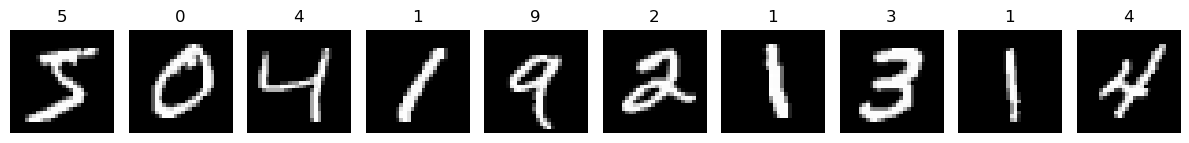

In [12]:
show_samples(train_dataset)

# Step 3: Define the Model

In [13]:
from torch import nn

In [14]:
class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(320, 50),
            nn.Linear(50, 10),
        )

    def forward(self, x):
        x = self.fc(x)
        return x

In [15]:
model = MNIST_CNN()

# Step 3.5: Verification

In [16]:
from torchinfo import summary as ti_sm

In [17]:
ti_sm(model, (64, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
MNIST_CNN                                [64, 10]                  --
├─Sequential: 1-1                        [64, 10]                  --
│    └─Conv2d: 2-1                       [64, 10, 24, 24]          260
│    └─ReLU: 2-2                         [64, 10, 24, 24]          --
│    └─MaxPool2d: 2-3                    [64, 10, 12, 12]          --
│    └─Conv2d: 2-4                       [64, 20, 8, 8]            5,020
│    └─ReLU: 2-5                         [64, 20, 8, 8]            --
│    └─MaxPool2d: 2-6                    [64, 20, 4, 4]            --
│    └─Flatten: 2-7                      [64, 320]                 --
│    └─Linear: 2-8                       [64, 50]                  16,050
│    └─Linear: 2-9                       [64, 10]                  510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 31.21
Input size (MB): 0.20
Forward/backw

# Step 4: Define Trainning Scheme

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [19]:
from tqdm import tqdm as tq

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
device

device(type='cpu')

In [21]:
num_epochs = 20
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tq(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        running_loss += loss_value

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

Epoch 20/20: 100%|██████████| 938/938 [00:05<00:00, 167.06it/s]


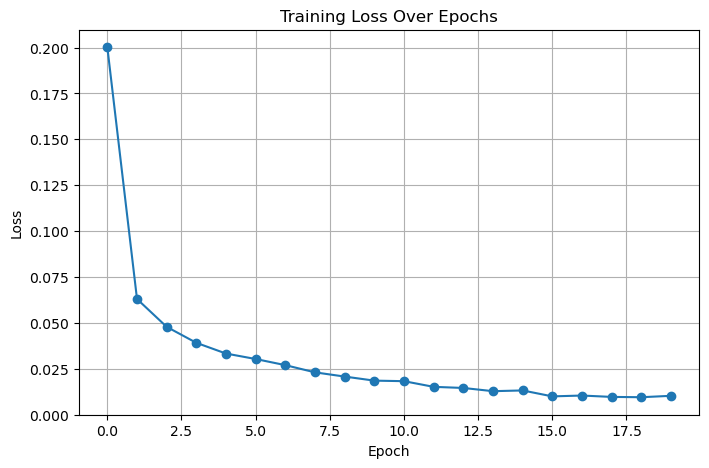

In [22]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, marker='o')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Step 4.5: Preservation

In [23]:
torch.save(model.state_dict(), './MNIST-MODEL.pth')

# Step 5: Test and Report

In [24]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(targets.numpy())

In [25]:
from sklearn.metrics import confusion_matrix as cfm, ConfusionMatrixDisplay as CMD

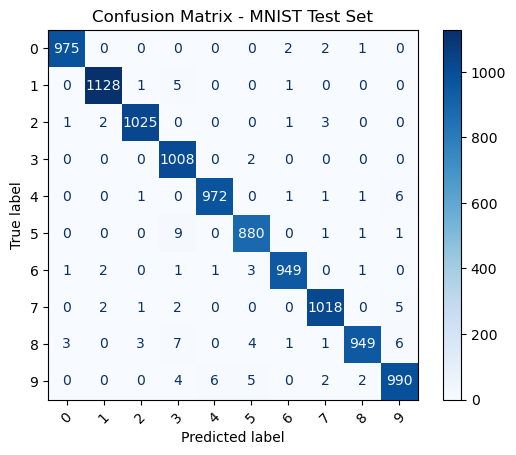

In [26]:
cm = cfm(all_labels, all_preds)
disp = CMD(confusion_matrix=cm, display_labels=list(range(10)))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - MNIST Test Set")
plt.grid(False)
plt.show()